## Use conda: ML_param kernel

In [4]:
%%time

import numpy as np
import torch
import gc
import random
import copy
import pickle
import mlflow
from torch import nn
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
from NN_models import NN_2_256, NN_4_256, NN_8_256, NN_8_64, NN_4_128, NN_8_128, MLOptimizer
from reaction_energy_calculation import calculate_reaction_energy, stack_reactions, get_local_energies_x, get_local_energies_c, backsplit
from prepare_data import prepare, save_chk, load_chk


def set_random_seed(seed):
    # seed everything
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(41)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# %%time
# data, data_train, data_test = prepare(path='data', test_size=0.2)

# %%time
# save_chk(data, data_train, data_test, path='checkpoints')

In [2]:
%%time
data, data_train, data_test = load_chk(path='checkpoints')

CPU times: user 4.37 s, sys: 4.09 s, total: 8.46 s
Wall time: 8.47 s


In [3]:
with open('./dispersions/dispersions.pickle', 'rb') as handle:
    dispersions = pickle.load(handle)

In [4]:
from dataset import collate_fn

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):

        self.data = data
        
    def __getitem__(self, i):
        self.data[i].pop('Database', None)
        return self.data[i], self.data[i]['Energy']
    
    def __len__(self):
        return len(self.data.keys())


train_set = Dataset(data=data_train)
train_dataloader = torch.utils.data.DataLoader(train_set, 
                                               batch_size=8,
                                               num_workers=4,
                                               pin_memory=True,
                                               shuffle=True, 
                                               collate_fn=collate_fn)

test_set = Dataset(data=data_test)
test_dataloader = torch.utils.data.DataLoader(test_set, 
                                              batch_size=8,
                                              num_workers=4,
                                              pin_memory=True,
                                              shuffle=True, 
                                              collate_fn=collate_fn)

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
criterion = nn.MSELoss()

# model = NN_4_256(nconstants=24, DFT='PBE').to(device)
# model.load_state_dict(torch.load('model_chk/predopt/PBE_32_32.param', map_location=device))

In [6]:
%%time
from dataset import collate_fn_predopt
from predopt import DatasetPredopt, true_constants_PBE
train_predopt_set = DatasetPredopt(data=data, dft='PBE')
train_predopt_dataloader = torch.utils.data.DataLoader(train_predopt_set,
                                                       batch_size=8,
                                                       num_workers=4,
                                                       pin_memory=True,
                                                       shuffle=True,
                                                       collate_fn=collate_fn_predopt)
#batch_size=8

CPU times: user 2.38 ms, sys: 2.26 ms, total: 4.64 ms
Wall time: 3.49 ms


In [8]:
model = MLOptimizer(num_layers=8, h_dim=32, nconstants=24, DFT='PBE').to(device)

In [7]:
model = mlflow.pytorch.load_model("mlruns/345453929293041957/dbdced7ecb014185b71403ae9cdcb7ef/artifacts/predopt_sigmoid_8x32_20_epochs")

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.01)
#3e-3
#removed weight_decay=0.01

In [8]:
from importlib import reload
import predopt
reload(predopt)
import utils
reload(utils)
import dataset
reload(dataset)

<module 'dataset' from '/home/duzaripov/ML-parameterization-of-DFT-functionals/dataset.py'>

In [12]:
#optimizer.param_groups[0]['lr'] = 3e-4

In [11]:
from predopt import predopt
train_loss_mae, test_loss_mae = predopt(model, criterion, optimizer, train_predopt_dataloader, device, n_epochs=20, accum_iter=1)

Epoch 1


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.52986740
train MAE Loss = 0.27641156
Epoch 2


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.02693687
train MAE Loss = 0.07253341
Epoch 3


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00937182
train MAE Loss = 0.04042327
Epoch 4


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00470607
train MAE Loss = 0.02963621
Epoch 5


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00371060
train MAE Loss = 0.02482430
Epoch 6


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00324407
train MAE Loss = 0.02254009
Epoch 7


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00278450
train MAE Loss = 0.02046171
Epoch 8


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00252033
train MAE Loss = 0.01934416
Epoch 9


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00230504
train MAE Loss = 0.01853688
Epoch 10


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00200721
train MAE Loss = 0.01716208
Epoch 11


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00173946
train MAE Loss = 0.01596626
Epoch 12


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00158716
train MAE Loss = 0.01523914
Epoch 13


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00141850
train MAE Loss = 0.01447157
Epoch 14


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00129727
train MAE Loss = 0.01382468
Epoch 15


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00115904
train MAE Loss = 0.01311082
Epoch 16


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00105678
train MAE Loss = 0.01244093
Epoch 17


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00094041
train MAE Loss = 0.01173740
Epoch 18


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00086927
train MAE Loss = 0.01120624
Epoch 19


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00079350
train MAE Loss = 0.01068455
Epoch 20


  0%|          | 0/34 [00:00<?, ?it/s]

train MSE Loss = 0.00073950
train MAE Loss = 0.01027737


In [9]:
def log_params(model, train_loss_mae, test_loss_mae, name):
    with mlflow.start_run() as run:
        mlflow.pytorch.log_model(model, name)
        mlflow.log_metric("train_mae", train_loss_mae[-1])
        mlflow.log_metric("test_mae",test_loss_mae[-1])
        plt.plot(np.arange(len(train_loss_mae)), train_loss_mae, label="train_mae_loss")
        plt.plot(test_loss_mae, label="test_mae_loss")
        plt.legend()
        plt.xlabel("number of epochs")
        plt.ylabel("MAE")
        plt.savefig(f"{name}.png")
        mlflow.log_artifact(f"{name}.png")

In [10]:
import matplotlib.pyplot as plt
mlflow.set_experiment("sigmoid_8x32_vanilla")
log_params(model, train_loss_mae, test_loss_mae, name="predopt_sigmoid_8x32_20_epochs")

KeyboardInterrupt: 

In [ ]:
#!mlflow ui --port 9000

[2023-05-11 08:12:34 +0300] [169257] [INFO] Starting gunicorn 20.1.0
[2023-05-11 08:12:34 +0300] [169257] [INFO] Listening at: http://127.0.0.1:9000 (169257)
[2023-05-11 08:12:34 +0300] [169257] [INFO] Using worker: sync
[2023-05-11 08:12:34 +0300] [169302] [INFO] Booting worker with pid: 169302
[2023-05-11 08:12:34 +0300] [169303] [INFO] Booting worker with pid: 169303
[2023-05-11 08:12:34 +0300] [169308] [INFO] Booting worker with pid: 169308
[2023-05-11 08:12:34 +0300] [169314] [INFO] Booting worker with pid: 169314


In [31]:
#torch.save(model.state_dict(), 'model_chk/predopt/PBE_8_32.param')

In [12]:
# !cp model_chk/predopt/PBE_4_256.param model_chk/predopt/PBE_4_256.param_backup3

In [11]:
torch.cuda.empty_cache()

In [12]:
from tqdm.notebook import tqdm
import os

log_file_path = 'log/epoch_training.log'

if os.path.isfile(log_file_path):
    os.remove(log_file_path)
    
mae = nn.L1Loss()

In [13]:
def exc_loss(reaction, pred_constants, true_constants = true_constants_PBE):
        backsplit_ind=reaction["backsplit_ind"].to(torch.int32)
        indices = list(zip(torch.hstack((torch.tensor(0).to(torch.int32),backsplit_ind)),backsplit_ind))
        n_molecules = len(indices)
        loss = torch.tensor(0., requires_grad=True).to(device)
        predicted_local_energies_x = get_local_energies_x(reaction, pred_constants, device, rung='GGA', dft='PBE')["Local_energies"]
        predicted_local_energies_x = [predicted_local_energies_x[start:stop] for start,stop in indices]
        predicted_local_energies_c = get_local_energies_c(reaction, pred_constants, device, rung='GGA', dft='PBE')["Local_energies"]
        predicted_local_energies_c = [predicted_local_energies_c[start:stop] for start,stop in indices]
        true_local_energies_x = get_local_energies_x(reaction, true_constants.to(device), device, rung='GGA', dft='PBE')["Local_energies"]
        true_local_energies_x = [true_local_energies_x[start:stop] for start,stop in indices]
        true_local_energies_c = get_local_energies_c(reaction, true_constants.to(device), device, rung='GGA', dft='PBE')["Local_energies"]
        true_local_energies_c = [true_local_energies_c[start:stop] for start,stop in indices]
        for i in range(n_molecules):
            loss+=1/len(predicted_local_energies_x[i])\
            *torch.sqrt(\
            torch.sum((predicted_local_energies_x[i]-true_local_energies_x[i])**2)\
            +torch.sum((predicted_local_energies_c[i]-true_local_energies_c[i])**2))
        return loss
def reg_loss(preds, coef=1):
    return coef*torch.exp(torch.abs(torch.mean(preds/true_constants_PBE-1)))

In [14]:
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs=25, accum_iter=1, verbose=False):
    train_loss_mae = []
    train_loss_mse = []
    test_loss_mae = []
    test_loss_mse = []
    omega = 0.067

    for epoch in range(n_epochs):
        torch.autograd.set_detect_anomaly(True)
        print(f'Epoch {epoch+1}')
        # train
        model.train()
        progress_bar_train = tqdm(train_loader)
        train_mae_losses_per_epoch = []
        train_mse_losses_per_epoch = []
        optimizer.zero_grad()
        for batch_idx, (X_batch, y_batch) in enumerate(progress_bar_train):
            # print(f'batch_idx = {batch_idx}')
            X_batch_grid, y_batch = X_batch['Grid'].to(device), y_batch.to(device)
            predictions = model(X_batch_grid)
            reaction_energy = calculate_reaction_energy(X_batch, predictions, device, rung='GGA', dft='PBE', dispersions=dispersions).to(device)

            if verbose:
                print(f"{X_batch['Components']} pred {reaction_energy.item():4f} true {y_batch.item():4f}")
            loss = (1-omega)/15*criterion(reaction_energy, y_batch)+omega*200*exc_loss(X_batch, predictions)
#            loss = criterion(reaction_energy, y_batch)
            MSE = criterion(reaction_energy, y_batch).item()
            MAE = mae(reaction_energy, y_batch).item()
            train_mse_losses_per_epoch.append(MSE)
            train_mae_losses_per_epoch.append(MAE)
            progress_bar_train.set_postfix(MSE = MSE, MAE = MAE)
            
 #           with open(log_file_path, 'a') as f:
 #               f.write(f"{X_batch['Components']} pred {reaction_energy.item():4f} true {y_batch.item():4f} MSE {MSE:4f} MAE {MAE:4f}\n")
            
            # loss_accumulation
            loss = loss / accum_iter
            loss.backward()
            if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                optimizer.step()
                optimizer.zero_grad()
                
            del X_batch, X_batch_grid, y_batch, predictions, reaction_energy
            gc.collect()
            torch.cuda.empty_cache()
        
        train_loss_mse.append(np.mean(train_mse_losses_per_epoch))        
        train_loss_mae.append(np.mean(train_mae_losses_per_epoch))

        print(f'train MSE Loss = {train_loss_mse[epoch]:.8f} MAE Loss = {train_loss_mae[epoch]:.8f}')


        
        #test
        model.eval()
        progress_bar_test = tqdm(test_loader)
        test_mae_losses_per_epoch = []
        test_mse_losses_per_epoch = []
        with torch.no_grad():
            for X_batch, y_batch in progress_bar_test:
                X_batch_grid, y_batch = X_batch['Grid'].to(device), y_batch.to(device)
                # print(f"{X_batch['Components']}")
                predictions = model(X_batch_grid)
                reaction_energy = calculate_reaction_energy(X_batch, predictions, device, rung='GGA', dft='PBE', dispersions=dispersions).to(device)
                loss = criterion(reaction_energy, y_batch)
                MSE = loss.item()
                MAE = mae(reaction_energy, y_batch).item()
                test_mse_losses_per_epoch.append(MSE)
                test_mae_losses_per_epoch.append(MAE)
                progress_bar_test.set_postfix(MSE = MSE, MAE = MAE)

                
#                with open(log_file_path, 'a') as f:
#                    f.write(f"{X_batch['Components']} pred {reaction_energy.item():4f} true {y_batch.item():4f} MSE {MSE:4f} MAE {MAE:4f}\n")
                del X_batch, X_batch_grid, y_batch, predictions, reaction_energy, loss, MAE, MSE
                gc.collect()
                torch.cuda.empty_cache()
                
        test_loss_mse.append(np.mean(test_mse_losses_per_epoch))
        test_loss_mae.append(np.mean(test_mae_losses_per_epoch))

        print(f'test MSE Loss = {test_loss_mse[epoch]:.8f} MAE Loss = {test_loss_mae[epoch]:.8f}')

    return train_loss_mae, test_loss_mae

In [15]:
from importlib import reload
import PBE
import reaction_energy_calculation
import utils
import NN_models
reload(NN_models)
reload(utils)
reload(reaction_energy_calculation)
reload(PBE)

<module 'PBE' from '/home/duzaripov/ML-parameterization-of-DFT-functionals/PBE.py'>

In [34]:
#model = MLOptimizer(num_layers=8, h_dim=32, nconstants=24, DFT="PBE").to(device)
#model.zero_grad()
# model.load_state_dict(torch.load('model_chk/predopt/PBE_32_32.param', map_location=device))

In [16]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=3e-5)
#3e-5

In [22]:
#optimizer.param_groups[0]['lr'] = 1e-7

In [31]:
N_EPOCHS = 25
ACCUM_ITER = 1
train_loss_mae, test_loss_mae = train(model, criterion, optimizer,
                       train_dataloader, test_dataloader,
                       n_epochs=N_EPOCHS, accum_iter=ACCUM_ITER)

Epoch 1


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 63.51489823 MAE Loss = 5.86499524


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 81.72801018 MAE Loss = 6.65425154
Epoch 2


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 63.54738250 MAE Loss = 5.95217594


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 76.30918775 MAE Loss = 6.49612917
Epoch 3


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 61.71197725 MAE Loss = 5.79318500


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 79.20878247 MAE Loss = 6.63065522
Epoch 4


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 62.57902064 MAE Loss = 5.80988559


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 78.75058419 MAE Loss = 6.56859412
Epoch 5


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 66.15240539 MAE Loss = 5.90804832


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 94.33560344 MAE Loss = 6.96888549
Epoch 6


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 60.06932954 MAE Loss = 5.81090270


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 76.60754531 MAE Loss = 6.48176834
Epoch 7


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 61.89219305 MAE Loss = 5.76621894


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 85.54139764 MAE Loss = 6.93755014
Epoch 8


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 63.63367614 MAE Loss = 5.85512144


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 61.36694445 MAE Loss = 5.94645749
Epoch 9


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 67.43164861 MAE Loss = 6.09295096


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 66.92357458 MAE Loss = 6.11615276
Epoch 10


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 63.77869747 MAE Loss = 5.83566229


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 75.37610163 MAE Loss = 6.34027955
Epoch 11


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 67.33208070 MAE Loss = 6.02463551


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 76.88865934 MAE Loss = 6.49263852
Epoch 12


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 65.15812849 MAE Loss = 5.99620289


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 70.23839297 MAE Loss = 6.23674502
Epoch 13


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 58.78801522 MAE Loss = 5.70228286


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 76.54136276 MAE Loss = 6.42335790
Epoch 14


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 62.12971465 MAE Loss = 5.85024268


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 77.12921170 MAE Loss = 6.46460942
Epoch 15


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 59.34417025 MAE Loss = 5.72790160


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 62.10419628 MAE Loss = 6.03366552
Epoch 16


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 64.83943445 MAE Loss = 5.94696462


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 70.68252155 MAE Loss = 6.37005050
Epoch 17


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 57.16563793 MAE Loss = 5.58484715


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 71.00534630 MAE Loss = 6.39097490
Epoch 18


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 63.40431680 MAE Loss = 5.98848803


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 74.43565532 MAE Loss = 6.55633426
Epoch 19


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 65.28539488 MAE Loss = 6.00917785


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 79.33255386 MAE Loss = 6.62210982
Epoch 20


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 64.79292474 MAE Loss = 5.98365196


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 79.93191556 MAE Loss = 6.41530044
Epoch 21


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 67.91077833 MAE Loss = 6.07391888


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 72.51418659 MAE Loss = 6.16160624
Epoch 22


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 58.92820224 MAE Loss = 5.66323213


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 75.95211683 MAE Loss = 6.30861480
Epoch 23


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 63.71488769 MAE Loss = 5.85062317


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 72.63422040 MAE Loss = 6.06318215
Epoch 24


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 63.36069270 MAE Loss = 5.85797241


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 89.59898104 MAE Loss = 6.97350645
Epoch 25


  0%|          | 0/27 [00:00<?, ?it/s]

train MSE Loss = 65.95813398 MAE Loss = 6.03165530


  0%|          | 0/7 [00:00<?, ?it/s]

test MSE Loss = 81.10522597 MAE Loss = 6.67281076


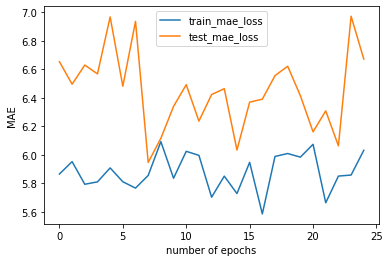

In [32]:
import matplotlib.pyplot as plt
mlflow.set_experiment("working_8x32_model")
log_params(model, train_loss_mae, test_loss_mae, name="trained_32x8_model")

In [35]:
X_batch, y_batch = next(iter(train_dataloader))
X_batch_grid = X_batch["Grid"].to(device)
preds = model(X_batch_grid)
torch.mean(preds/true_constants_PBE.to(device), axis=0)

tensor([1.0156, 0.9941, 1.0624, 0.9949, 1.1767, 1.2667, 1.0526, 0.9720, 0.9325,
        1.0827, 1.0227, 1.0304, 1.0278, 0.9836, 1.0414, 0.9762, 1.0059, 0.9211,
        0.9712, 1.0000, 0.9496, 0.9911, 1.0335, 1.0127], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [36]:
X_batch, y_batch = next(iter(train_dataloader))
X_batch_grid = X_batch["Grid"].to(device)
preds = model(X_batch_grid)
torch.mean(preds/true_constants_PBE.to(device), axis=0)

tensor([1.0064, 0.9927, 1.0299, 1.0634, 0.9496, 1.0190, 0.9888, 0.9959, 1.0376,
        1.0085, 1.0020, 1.0215, 1.0088, 0.9953, 1.0189, 0.9886, 1.0053, 0.9689,
        0.9892, 1.0032, 0.9775, 0.9924, 1.0190, 1.0125], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [44]:
X_batch, y_batch = next(iter(train_dataloader))
X_batch_grid = X_batch["Grid"].to(device)
preds = model(X_batch_grid)
torch.mean(preds/true_constants_PBE.to(device), axis=0)

OutOfMemoryError: CUDA out of memory. Tried to allocate 114.00 MiB (GPU 0; 31.75 GiB total capacity; 31.12 GiB already allocated; 75.94 MiB free; 31.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [41]:
del preds, X_batch, y_batch, X_batch_grid

NameError: name 'preds' is not defined

In [ ]:
def test_dft(train_loader, test_loader, c_arr, criterion, rung, dft, verbose=False, n_epochs=1, model_eval=False):
    train_loss_mae = []
    train_loss_mse = []
    test_loss_mae = []
    test_loss_mse = []

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}')
        # train

        progress_bar_train = tqdm(train_loader)
        train_mae_losses_per_epoch = []
        train_mse_losses_per_epoch = []
        for X_batch, y_batch in progress_bar_train:
            # print(f"{X_batch['Components']}")
            X_batch_grid, y_batch = X_batch['Grid'].to(device), y_batch.to(device)
            # print(torch.tile(c_arr, [X_batch_grid.shape[0],1]))
            if model_eval:
                predictions = model(X_batch_grid)
            else:
                predictions = torch.tile(c_arr, [X_batch_grid.shape[0],1]).to(device)
            reaction_energy = calculate_reaction_energy(X_batch, predictions, device, rung, dft)
            loss = criterion(reaction_energy, y_batch)
            MSE = loss.item()
            MAE = torch.abs(reaction_energy - y_batch).item()
            train_mse_losses_per_epoch.append(MSE)
            train_mae_losses_per_epoch.append(MAE)
            progress_bar_train.set_postfix(MSE = MSE, MAE = MAE)
            if verbose:
                print(f"{X_batch['Components']} pred {reaction_energy.item():4f} true {y_batch.item():4f} MSE {MSE:4f} MAE {MAE:4f}")

            del X_batch, X_batch_grid, y_batch, predictions, reaction_energy, loss, MAE, MSE
            gc.collect()
            torch.cuda.empty_cache()

        
        train_loss_mse.append(np.mean(train_mse_losses_per_epoch))        
        train_loss_mae.append(np.mean(train_mae_losses_per_epoch))

        print(f'train MSE Loss = {train_loss_mse[epoch]:.8f} MAE Loss = {train_loss_mae[epoch]:.8f}')


        
        #test
        progress_bar_test = tqdm(test_loader)
        test_mae_losses_per_epoch = []
        test_mse_losses_per_epoch = []
        for X_batch, y_batch in progress_bar_test:
            # print(f"{X_batch['Components']}")
            X_batch_grid, y_batch = X_batch['Grid'].to(device), y_batch.to(device)
            if model_eval:
                predictions = model(X_batch_grid)
            else:
                predictions = torch.tile(c_arr, [X_batch_grid.shape[0],1]).to(device)
            reaction_energy = calculate_reaction_energy(X_batch, predictions, device, rung, dft)
            loss = criterion(reaction_energy, y_batch)
            MSE = loss.item()
            MAE = torch.abs(reaction_energy - y_batch).item()
            # progress_bar_train.set_postfix(MAE = MAE)
            test_mse_losses_per_epoch.append(MSE)
            test_mae_losses_per_epoch.append(MAE)
            if verbose:
                print(f"{X_batch['Components']} pred {reaction_energy.item():4f} true {y_batch.item():4f} MSE {MSE:4f} MAE {MAE:4f}")
            
            del X_batch, X_batch_grid, y_batch, predictions, reaction_energy, loss, MAE, MSE
            gc.collect()
            torch.cuda.empty_cache()
                
        test_loss_mse.append(np.mean(test_mse_losses_per_epoch))
        test_loss_mae.append(np.mean(test_mae_losses_per_epoch))

        print(f'test MSE Loss = {test_loss_mse[epoch]:.8f} MAE Loss = {test_loss_mae[epoch]:.8f}')

    return train_loss_mae

In [ ]:
from importlib import reload
import NN_models
reload(NN_models)
from NN_models import NN_2_256, NN_8_256, NN_8_64
# import SVWN3

In [ ]:
from importlib import reload
import PBE
import reaction_energy_calculation
import utils
import NN_models
reload(NN_models)
reload(utils)
reload(reaction_energy_calculation)
reload(PBE)

<module 'PBE' from '/home/duzaripov/ML-parameterization-of-DFT-functionals/PBE.py'>

In [ ]:
true_constants_SVWN = torch.Tensor([0.0310907, 0.01554535, 
                3.72744,   7.06042,
                12.9352,   18.0578,
                -0.10498,  -0.32500,
                0.0310907,  0.01554535,  -1/(6*torch.pi**2),
                13.0720,    20.1231,      1.06835,
                42.7198,   101.578,      11.4813,
                -0.409286,  -0.743294,   -0.228344,
                1])

true_constants_PBE = torch.Tensor([[0.06672455,
       (1 - torch.log(torch.Tensor([2])))/(torch.pi**2),
       1.709921,
       7.5957, 14.1189, 10.357,
       3.5876, 6.1977, 3.6231,
       1.6382, 3.3662,  0.88026,
       0.49294, 0.62517, 0.49671,
       # 1,  1,  1,
       0.031091, 0.015545, 0.016887,
       0.21370,  0.20548,  0.11125,
       -3/8*(3/torch.pi)**(1/3)*4**(2/3),
       0.8040,
       0.2195149727645171]])

par_rpw92_constants = torch.Tensor([[0.06672455,
       (1 - torch.log(torch.Tensor([2])))/(torch.pi**2),
       1.709920934161365617563962776245,
       7.5957, 14.1189, 10.357,
       3.5876, 6.1977, 3.6231,
       1.6382, 4.86059,  0.88026,
       0.49294, 0.750188, 0.49671,
       # 1,  1,  1,
       0.0310907, 0.01554535, 0.0168869,
       0.21370,  0.266529,  0.11125,
       -3/8*(3/torch.pi)**(1/3)*4**(2/3),
       0.8040,
       0.2195149727645171]])


# true_constants

test_dft(train_dataloader, test_dataloader, true_constants_PBE, criterion, rung='GGA', dft='PBE', verbose=False, model_eval=True)
# test_dft(train_dataloader, test_dataloader, true_constants_SVWN, criterion, rung='LDA', dft='SVWN3', verbose=False)

# broken_PBE 45.47375717 35.76542641
# Mean Absolute Error, kcal/mol
# DFT              train        test
# SVWN3            32.63222432 26.81526929
# PBE_sigma_broken 7.84055060  7.63013082
# PBE_fixed        7.85833597  7.64929252
# PBE_pred_4_256   27.07443217 29.64430402   

Epoch 1


  0%|          | 0/108 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b93f9b1a290>
Traceback (most recent call last):
  File "/opt/software/python/jupyterhub2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/software/python/jupyterhub2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/software/python/jupyterhub2/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/software/python/jupyterhub2/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/software/python/jupyterhub2/lib/python3.10/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/opt/software/python/jupyterhub2/lib/python3.10/selectors.py", line 416, in select
    fd_event_

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [77]:
from importlib import reload
import PBE
import reaction_energy_calculation
import utils
import NN_models
reload(NN_models)
reload(utils)
reload(reaction_energy_calculation)
reload(PBE)
from reaction_energy_calculation import calculate_reaction_energy

In [78]:
from importlib import reload
import PBE
reload(PBE)
# from PBE_new import F_PBE_new

<module 'PBE' from '/home/duzaripov/ML-parameterization-of-DFT-functionals/PBE.py'>

In [100]:
res_A = torch.load('log/res_A.pt')

In [101]:
assert not torch.isnan(res_A).any()